In [2]:
import results_reader.results_reader as rr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [92]:
legend = [("MySQL", "InnoDB", "purple"),
          ("MySQL", "MyISAM", "orange"),
          ("MariaDB", "InnoDB", "green"),
          ("MariaDB", "Aria", "pink"),
          ("MSSQL", "MSSQL", "red"),
          ("Oracle", "Oracle", "brown"),
          ("Postgres", "Postgres", "blue")]

In [3]:
mysql_innodb_path = r"C:\Users\szymon\OneDrive\praca_inzyneirska\wyniki\mysql_innodb"
mysql_myisam_path = r"C:\Users\szymon\OneDrive\praca_inzyneirska\wyniki\mysql_myisam"
mariadb_innodb_path = r"C:\Users\szymon\OneDrive\praca_inzyneirska\wyniki\mariadb_innodb"
mariadb_aria_path = r"C:\Users\szymon\OneDrive\praca_inzyneirska\wyniki\mariadb_aria"
mssql_path = r"C:\Users\szymon\OneDrive\praca_inzyneirska\wyniki\mssql"
postgres_path = r"C:\Users\Szymon\OneDrive\praca_inzyneirska\wyniki\postgres"
oracle_path = r"C:\Users\Szymon\OneDrive\praca_inzyneirska\wyniki\oracle"
cpu_cores_mapper = rr.CPUCoresMapper({"results_1cpus": 1,
                                   "results_2cpus": 2,
                                   "results_4cpus": 4})
indexing_mapper = rr.IndexingMapper({"before_index": False,
                                  "after_index": True})

In [4]:
df = rr.DatabaseResultsReader(mysql_innodb_path, "MySQL", "InnoDB", cpu_cores_mapper, indexing_mapper).getDataFrame(2)
df = df.append(rr.DatabaseResultsReader(mysql_myisam_path, "MySQL", "MyISAM", cpu_cores_mapper, indexing_mapper).getDataFrame(2), ignore_index=True)
df = df.append(rr.DatabaseResultsReader(mariadb_innodb_path, "MariaDB", "InnoDB", cpu_cores_mapper, indexing_mapper).getDataFrame(2), ignore_index=True)
df = df.append(rr.DatabaseResultsReader(mssql_path, "MSSQL", "MSSQL", cpu_cores_mapper, indexing_mapper).getDataFrame(2), ignore_index=True)
df = df.append(rr.DatabaseResultsReader(postgres_path, "Postgres", "Postgres", cpu_cores_mapper, indexing_mapper).getDataFrame(2), ignore_index=True)
df = df.append(rr.DatabaseResultsReader(mariadb_aria_path, "MariaDB", "Aria", cpu_cores_mapper, indexing_mapper).getDataFrame(2), ignore_index=True)
df = df.append(rr.DatabaseResultsReader(oracle_path, "Oracle", "Oracle", cpu_cores_mapper, indexing_mapper).getDataFrame(2), ignore_index=True)

In [5]:
ddf = df[(df['test_name'] == rr.TestName.LOG.value) & (df['query_type'] == rr.QueryType.ALL.value.upper())]

In [6]:
log_all_df = ddf[['database', 'engine', 'real', 'result_size']].groupby(['database', 'engine', 'result_size']).mean().reset_index()

<AxesSubplot:xlabel='result_size'>

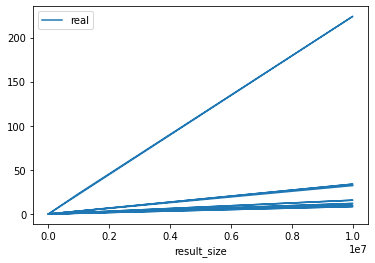

In [7]:
log_all_df.plot.line(x='result_size', y='real', legend='true')

In [8]:
log_all_df[(log_all_df['database'] == 'MSSQL') & (log_all_df['engine'] == 'MSSQL')][['result_size', 'real']]

,result_size,real
0,1.0,0.014417
1,10.0,0.012550
2,100.0,0.014000
3,1000.0,0.017800
4,10000.0,0.052467
5,100000.0,0.352767
6,1000000.0,3.372517
7,10000000.0,33.896333


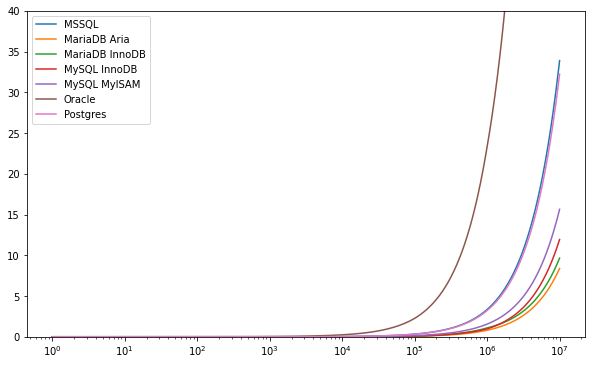

In [9]:
# plot logarithmically results
fig, ax = plt.subplots(figsize=(10, 6))
for database, engine in list(log_all_df[['database', 'engine']].groupby(['database', 'engine']).groups.keys()):
    plot_df = log_all_df[(log_all_df['database'] == database) & (log_all_df['engine'] == engine)]
    plot_df = plot_df[['result_size', 'real']]
    plot_df = plot_df.append(pd.DataFrame([val for val in (np.arange(100, 10000000, 100)) if val not in [100, 1000, 10000, 100000, 1000000]], columns=['result_size']))
    plot_df = plot_df.sort_values('result_size')
    plot_df = plot_df.set_index('result_size')
    plot_df = plot_df.interpolate()
    if database != engine:
        label = f"{database} {engine}"
    else:
        label = database
    ax.plot(plot_df, label=label)
ax.set_xscale("log")
ax.set_ylim([0, 40])
ax.legend()
plt.show()

In [90]:
def plot_results_log(df_results, test_name, query_type, path=None, yMin=0, yMax=0, xMin=1, xMax=10000000):
    df = df_results[(df_results['test_name'] == test_name) & (df_results['query_type'] == query_type.upper())]
    df = df[['database', 'engine', 'real', 'result_size']].groupby(['database', 'engine', 'result_size']).mean().reset_index()
    width = 10
    height = 6
    if(path):
        width = 25
        height = 10
    fig, ax = plt.subplots(figsize=(width, height))
    for database, engine, color in legend:
        plot_df = df[(df['database'] == database) & (df['engine'] == engine)]
        plot_df = plot_df[['result_size', 'real']]
        plot_df = plot_df[(plot_df["result_size"] >= xMin) & plot_df["result_size"] <= xMax]
        plot_df = plot_df.append(pd.DataFrame([val for val in (np.arange((100 if xMin == 1 else xMin), xMax, 100)) if val not in [100, 1000, 10000, 100000, 1000000]], columns=['result_size']))
        plot_df = plot_df.sort_values('result_size')
        plot_df = plot_df.set_index('result_size')
        plot_df = plot_df.interpolate()
        if database != engine:
            label = f"{database} {engine}"
        else:
            label = database
        ax.plot(plot_df, label=label, color=color)
    ax.set_xscale("log")
    yMax = df['real'].max() if yMax == 0 else yMax;
    ax.set_ylim([yMin, yMax])
    ax.set_ylabel('Czas [s]')
    ax.set_xlim([xMin, xMax])
    ax.set_xlabel('Rozmiar tabeli')
    ax.legend(fontsize='large', loc='upper left')
    if path:
        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize("large")
        fig.savefig(path, bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [93]:
plot_results_log(df_results, rr.TestName.LOG.value, rr.QueryType.ALL.value, yMax=40, path=r"C:\Users\Szymon\source\repos\praca_inz_repo\db_perf_tests\plot.png")